In [15]:
import tqdm as tqdm
import torch
import numpy
import pickle as pkl
from utils.head import end2end
from utils.dataset import load_compiled_data, aircraft_camera_data
from torch.utils.data import DataLoader
import torch.nn as nn
import cv2

from utils.head import *
device = torch.device('cuda:0')

In [4]:
t = 3 # Time - 5
w = 1 # Weather - 5
r = 1 # Runs - 3

data_indexes = [1,2] # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

In [5]:
n = 4500
img = acd.get_frame_from_video(n, size = (1280, 1920), batch_size = 1).cuda()

In [6]:
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],[1909.443359375, 396.5, 172.640625, 83.5]]
model = end2end('models/config/model_m_m.yaml', model_state_dict='models/head/big_dataset/kaiming_3/m_m.pt', offset = offset, divider = divider, device = device)

Input_Reg Aux DE Loaded


In [7]:
box, score, pred = model.single_infer(img)

Time Profile:

Object Detector    : 591.08 ms
Preprocessing      : 0.42 ms
Distance Estimator : 139.34 ms

Total Time         : 730.84 ms (1.3682805704866243 FPS)
            


In [8]:
gt = acd.get_current_dtt(n)
print(f'{pred - gt} nm')

0.0020683222137294344 nm


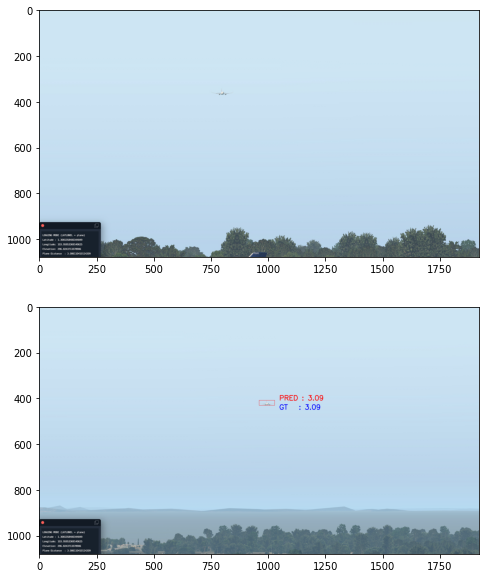

In [20]:
vis(img, gt, box, score, pred)

In [21]:
def vis(img, gt, box, score, pred, size =(1080, 1920), fig = None, ax = None):
    img = img[0]
    if fig == None or ax == None:
        fig, ax = plt.subplots(1,img.shape[0],figsize=(10,10))
    ax = ax.ravel()
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().detach().numpy()
    else:
        img = np.ascontiguousarray(img)
        
    for i in range(len(box)):
        c1, c2 = ((int(box[i][0]), int(box[i][1])), (int(box[i][2]), int(box[i][3])))
        if c1 == (0,0) or c2 == (0,0):
            continue
            
        label_pred = f'PRED : {pred:.2f}'
        label_gt =   f'GT   : {gt:.2f}'
        tl = 1
        tf = 2
        color = [1,0,0]
        cv2.rectangle(img[i], c1, c2, color, thickness=1, lineType=cv2.LINE_AA)
        t_size = cv2.getTextSize(label_pred, 0, tl, tf)[0]
        if c2[0] + 20 + t_size[0] < img.shape[1]:
            cv2.putText(img[i], label_pred, (c2[0] + 20, c1[1]), 0, tl , [1, 0, 0], thickness=tf, lineType=cv2.LINE_AA)
            cv2.putText(img[i], label_gt, (c2[0] + 20, c1[1] + 40), 0, tl , [0, 0, 1], thickness=tf, lineType=cv2.LINE_AA)
        else:
            cv2.putText(img[i], label_pred, (c1[0] - t_size[0] - 20, c1[1]), 0, tl , [1, 0, 0], thickness=tf, lineType=cv2.LINE_AA)
            cv2.putText(img[i], label_gt, (c1[0] - t_size[0] - 20, c1[1] + 40), 0, tl , [0, 0, 1], thickness=tf, lineType=cv2.LINE_AA)
        
    for i in range(len(ax)):
        ax[i].imshow(img[i][:size[0], :size[1]])